# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### The height problem

For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.  Suppose you learn that someone is 170 cm tall.  What is the probability that they are male? 

Run this analysis again for a range of observed heights and plot a curve that shows P(male) versus height.  What is the mathematical form of this function?

To represent the likelihood functions, I'll use `norm` from `scipy.stats`, which returns a "frozen" random variable (RV) that represents a normal distribution with given parameters.


In [3]:
from scipy.stats import norm

dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

{'male': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fec1ce68390>,
 'female': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fec1ce684e0>}

Write a class that implements `Likelihood` using the frozen distributions.  Here's starter code:

In [4]:
class Height(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        return 1

In [5]:
# Solution

class Height(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: height in cm
        hypo: 'male' or 'female'
        """
        height = data
        return dist_height[hypo].pdf(height)

Here's the prior.

In [6]:
suite = Height(dict(male=0.49, female=0.51))
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.49
female 0.51


And the update:

In [7]:
suite.Update(170)
for hypo, prob in suite.Items():
    print(hypo, prob)

male 0.45677745168681627
female 0.5432225483131837


Compute the probability of being male as a function of height, for a range of values between 150 and 200.

In [8]:
# Solution

def prob_male(height):
    suite = Height(dict(male=0.49, female=0.51))
    suite.Update(height)
    return suite['male']

In [9]:
# Solution

heights = np.linspace(130, 210)
series = pd.Series(index=heights)

for height in heights:
    series[height] = prob_male(height)

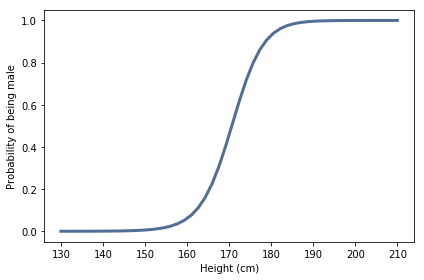

In [10]:
# Solution

thinkplot.plot(series)
thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='Probability of being male')

If you are curious, you can derive the mathematical form of this curve from the PDF of the normal distribution.

### How tall is A?

Suppose I choose two residents of the U.S. at random.  A is taller than B.  How tall is A?

What if I tell you that A is taller than B by more than 5 cm.  How tall is A?

For adult male residents of the US, the mean and standard deviation of height are 178 cm and 7.7 cm.  For adult female residents the corresponding stats are 163 cm and 7.3 cm.

Here are distributions that represent the heights of men and women in the U.S.

In [11]:
dist_height = dict(male=norm(178, 7.7),
                   female=norm(163, 7.3))

{'male': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fec1cb59128>,
 'female': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fec1cb94d68>}

In [12]:
hs = np.linspace(130, 210)
ps = dist_height['male'].pdf(hs)
male_height_pmf = Pmf(dict(zip(hs, ps)));

In [13]:
ps = dist_height['female'].pdf(hs)
female_height_pmf = Pmf(dict(zip(hs, ps)));

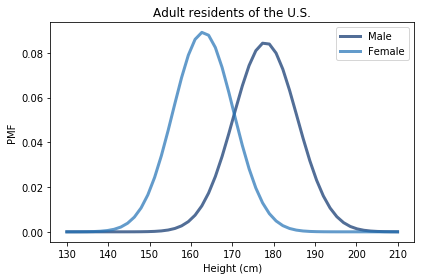

In [14]:
thinkplot.Pdf(male_height_pmf, label='Male')
thinkplot.Pdf(female_height_pmf, label='Female')

thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Adult residents of the U.S.')

Use `thinkbayes2.MakeMixture` to make a `Pmf` that represents the height of all residents of the U.S.

In [38]:
# Solution

from thinkbayes2 import MakeMixture

metapmf = Pmf({male_height_pmf:0.49, female_height_pmf:0.51})
mix = MakeMixture(metapmf)
mix.Mean()

170.34986539085568

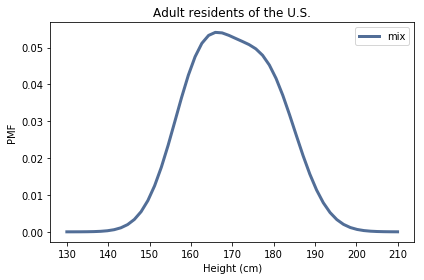

In [39]:
# Solution

thinkplot.Pdf(mix)

thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Adult residents of the U.S.')

Write a class that inherits from Suite and Joint, and provides a Likelihood function that computes the probability of the data under a given hypothesis.

In [40]:
# Solution

class Heights(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: who is taller, 'A' or 'B'?
        hypo: h1, h2
        """
        h1, h2 = hypo
        if data == 'A':
            return 1 if h1 > h2 else 0
        else:
            return 1 if h2 > h1 else 0

Write a function that initializes your `Suite` with an appropriate prior.

In [41]:
# Solution

# We could also use MakeJoint for this

def make_prior(A, B):
    suite = Heights()

    for h1, p1 in A.Items():
        for h2, p2 in B.Items():
            suite[h1, h2] = p1 * p2
    return suite

In [42]:
suite = make_prior(mix, mix)
suite.Total()

1.0000000000000022

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


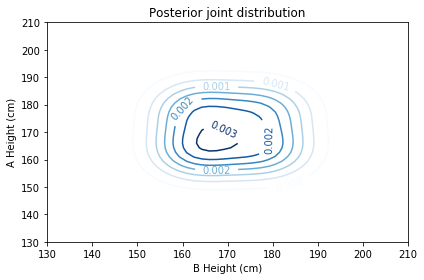

In [43]:
thinkplot.Contour(suite)
thinkplot.decorate(xlabel='B Height (cm)',
                   ylabel='A Height (cm)',
                   title='Posterior joint distribution')

Update your `Suite`, then plot the joint distribution and the marginal distribution, and compute the posterior means for `A` and `B`.

In [44]:
# Solution

suite.Update(0)

0.47896674401037115

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


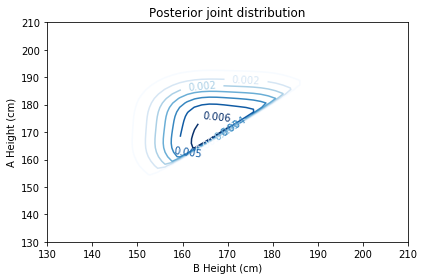

In [45]:
# Solution

thinkplot.Contour(suite)

thinkplot.decorate(xlabel='B Height (cm)',
                   ylabel='A Height (cm)',
                   title='Posterior joint distribution')

(164.05298129722948, 176.67506663725243)

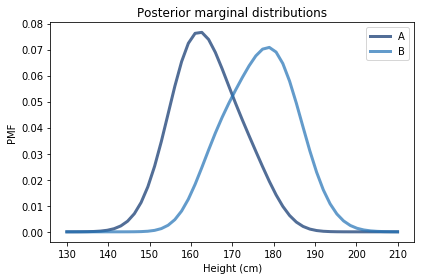

In [46]:
# Solution

posterior_a = suite.Marginal(0)
posterior_b = suite.Marginal(1)

thinkplot.Pdf(posterior_a, label='A')
thinkplot.Pdf(posterior_b, label='B')
thinkplot.decorate(xlabel='Height (cm)',
                   ylabel='PMF',
                   title='Posterior marginal distributions')

posterior_a.Mean(), posterior_b.Mean()

### Second tallest problem

In a room of 10 randomly chosen U.S. residents, A is the second tallest.  How tall is A?  What is the probability that A is male?

In [47]:
# Solution

# The prior for A and B is the mixture we computed above.

A = mix
B = mix;

In [48]:
# Solution

def faceoff(player1, player2, data):
    """Compute the posterior distributions for both players.
    
    player1: Pmf
    player2: Pmf
    data: margin by which player1 beats player2
    """
    joint = make_prior(player1, player2)
    joint.Update(data)
    return joint.Marginal(0), joint.Marginal(1)

In [49]:
# Solution

# We can think of the scenario as a sequence of "faceoffs"
# where A wins 8 and loses 1

for i in range(8):
    A, _ = faceoff(A, B, 'A')
    
A, B = faceoff(A, B, 'B');

181.60660153115964

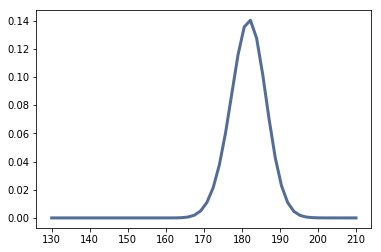

In [50]:
# Solution

# Here's the posterior distribution for A

thinkplot.Pdf(A)
A.Mean()

In [51]:
# Solution

# Now we can compute the total probability of being male,
# conditioned on the posterior distribution of height.

total = 0
for h, p in A.Items():
    total += p * prob_male(h)
total

0.9167980720726623

In [52]:
# Solution

# Here's a second solution based on an "annotated" mix that keeps
# track of M and F

annotated_mix = Suite()
for h, p in male_height_pmf.Items():
    annotated_mix['M', h] = p * 0.49
    
for h, p in female_height_pmf.Items():
    annotated_mix['F', h] = p * 0.51
    
annotated_mix.Total()

0.9999999999999999

In [53]:
# Solution

# Here's an updated Heights class that can handle the
# annotated mix

class Heights2(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: who is taller, A or B
        hypo: (MF1, h1), (MF2, h2)
        """
        (_, h1), (_, h2) = hypo
        if data == 'A':
            return 1 if h1 > h2 else 0
        if data == 'B':
            return 1 if h2 > h1 else 0

In [54]:
# Solution

# Everything else is pretty much the same

from thinkbayes2 import MakeJoint

def faceoff(player1, player2, data):
    joint = Heights2(MakeJoint(player1, player2))
    joint.Update(data)
    return joint.Marginal(0), joint.Marginal(1)

In [55]:
# Solution

A = annotated_mix
B = annotated_mix;

In [56]:
# Solution

for i in range(8):
    A, _ = faceoff(A, B, 'A')
    
A, _ = faceoff(A, B, 'B');

In [57]:
# Solution

# Now the posterior distribution for A contains the
# probability of being male

A_male = Joint(A).Marginal(0)

Pmf({'M': 0.9167985976340078, 'F': 0.0832014023659922})

181.60660153115973

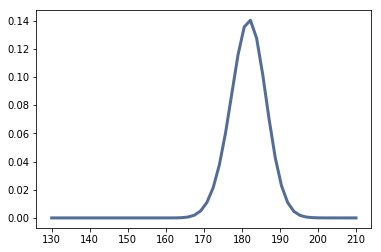

In [58]:
# Solution

# The posterior distribution for A also contains the
# posterior probability of height

A_height = Joint(A).Marginal(1)

thinkplot.Pdf(A_height)
A_height.Mean()